In [36]:
QWEN = "qwen3:1.7b"
GPT_OSS = "gpt-oss-bn-json"
MODEL = GPT_OSS
MODEL_QUIZ = "qwen2.5:7b"

In [ ]:
import random as _random

def create_dependency_quiz(net, node1, node2, rng=None):
    """
    Builds two multiple-choice questions about dependency and d-separation, with
    randomized answer order. Returns (questions_text, answers_letters).

    - answers_letters: list like ["A", "C"] indicating the correct choice per question
    - rng: optional random-like object with .shuffle(list) and .choice(...)
    """
    from bn_helpers.bn_helpers import BnHelper
    from bn_helpers.utils import get_path

    randomizer = rng or _random

    bn_helper = BnHelper(function_name='is_XY_connected')
    is_connected = bn_helper.is_XY_connected(net, node1, node2)

    # Q1: Is changing evidence of node1 going to change probability of node2?
    q1_prompt = f"1. Is changing the evidence of {node1} going to change the probability of {node2}?"
    q1_options = [
        ("Yes", is_connected),
        ("No", not is_connected),
        ("None of the above", False),
    ]
    randomizer.shuffle(q1_options)
    q1_lines = [q1_prompt]
    q1_correct_letter = None
    for idx, (text, correct) in enumerate(q1_options):
        letter = chr(65 + idx)  # A, B, C
        q1_lines.append(f"{letter}. {text}")
        if correct:
            q1_correct_letter = letter

    # Q2: d-connected or d-separated explanation
    if is_connected:
        option_texts = [
            (f"They are d-connected through the path {get_path(net, node1, node2)}", True),
            ("They are not d-connected", False),
            ("None of the above", False),
        ]
        q2_header = "2. Why they are d-connected?"
    else:
        common_effect = bn_helper.get_common_effect(net, node1, node2)
        because_text = (
            f"They are d-separated because they are blocked by {common_effect}"
            if common_effect
            else f"There are no path between {node1} and {node2}"
        )
        option_texts = [
            (because_text, True),
            ("They are not d-separated", False),
            ("None of the above", False),
        ]
        q2_header = "2. Why they are d-separated?"

    randomizer.shuffle(option_texts)
    q2_lines = ["", q2_header]  # blank line between Q1 and Q2
    q2_correct_letter = None
    for idx, (text, correct) in enumerate(option_texts):
        letter = chr(65 + idx)
        q2_lines.append(f"{letter}. {text}")
        if correct:
            q2_correct_letter = letter

    questions = "\n".join(q1_lines + q2_lines)
    answers = [q1_correct_letter, q2_correct_letter]

    return questions, answers



# Build Net

In [2]:
import os
from bni_netica.bni_netica import Net
from benchmarking.data_generator import build_random_bn
from bn_helpers.get_structures_print_tools import get_nets, printNet, get_BN_structure, printPath
from benchmarking.data_utils import save_nets_to_parquet, load_nets_from_parquet
from benchmarking.benchmarking_utils import pickTwoRandomNodes
from bn_helpers.bn_helpers import AnswerStructure, BnHelper
from ollama.prompt import answer_this_prompt, generate_chat
from bn_helpers.utils import get_path


Loading Netica


In [3]:
output_path = "./nets/outputs/"

# net3 = build_random_bn(
#     n_nodes=12,
#     name="SkewBN",
#     cpt_mode="random",
#     dirichlet_alpha=0.3,     # spiky rows
#     avg_edges_per_node=1.4,
#     max_in_degree=2,
#     sprinkle_motifs=5,
#     # save_path=output_path
# )

# printNet(net3)

## Test the boundary

In [4]:
# net2 = build_random_bn(
#     n_nodes=60,
#     name="MaxRandomBN",
#     cpt_mode="random",
#     avg_edges_per_node=5,
#     max_in_degree=5,
#     sprinkle_motifs=5,
#     # save_path=output_path
# )

# printNet(net2)


# Build Dataset

In [5]:
# import all nets from the collection
nets_collection = get_nets()

# print all nets
for net in nets_collection:
    printNet(net)
    print()

A -> ['B', 'C']
B -> ['D']
C -> ['D', 'E']
D -> []
E -> []

VisitAsia -> ['Tuberculosis']
Tuberculosis -> ['TbOrCa']
Smoking -> ['Cancer', 'Bronchitis']
Cancer -> ['TbOrCa']
TbOrCa -> ['XRay', 'Dyspnea']
XRay -> []
Bronchitis -> ['Dyspnea']
Dyspnea -> []

Class -> ['Obsv', 'Result']
Obsv -> ['Classifier']
Classifier -> ['Result']
Result -> []

Sex -> ['Smoking_status', 'LVH', 'Coronary_artery_disease']
Smoking_status -> ['Coronary_artery_disease']
Systolic_Blood_Pressure -> ['LVH', 'Coronary_artery_disease']
Age -> ['LVH', 'Coronary_artery_disease']
LVH -> ['Coronary_artery_disease']
Diabetes_mellitus -> ['Coronary_artery_disease']
Total_chol -> ['Coronary_artery_disease']
HDL_Status -> ['Coronary_artery_disease']
Coronary_artery_disease -> []

Tampering -> ['Alarm']
Fire -> ['Alarm', 'Smoke']
Alarm -> ['Leaving']
Leaving -> ['Report']
Smoke -> []
Report -> []

P1 -> ['C', 'Color_P1']
P2 -> ['C', 'Color_P2']
C -> ['Color_C']
Color_P1 -> []
Color_C -> []
Color_P2 -> []

Ecstazine -> ['N

In [6]:
data_output = "./benchmarking/data"

In [7]:
# # Generate 500 random nets
# nets = nets_collection + \
# [ 
#     build_random_bn(n_nodes=i,
#         cpt_mode="random",
#         avg_edges_per_node=2,
#         max_in_degree=2,
#         sprinkle_motifs=5
#     )
#     for i in range(3,800)
# ]

# # Save them
# save_nets_to_parquet(nets, os.path.join(data_output, "nets_dataset_800.parquet"))

In [8]:
LOAD_NETS = False
# Load them back
if LOAD_NETS:
    loaded_nets = load_nets_from_parquet(os.path.join(data_output, "nets_dataset.parquet"))


In [9]:
# for net in loaded_nets[:20]:
#   printNet(net)
#   print()

# Benchmark simple Query: Is D-connected?

In [10]:
nets_collection = get_nets()

In [11]:
def get_explain_XY_dconnected(net, node1, node2):
    open_path = get_path(net, node1, node2)
    ans = (f"Yes, {node1} is d-connected to {node2}, "
          f"which means that entering evidence for {node1} would "
          f"change the probability of {node2} and vice versa. They d-connected through the following path: {open_path}")
    return ans

In [ ]:


printNet(nets_collection[-1])
targetNet = nets_collection[0]
targetBN = get_BN_structure(targetNet)

node1 = "B"
node2 = "C"

bn_helper = BnHelper(function_name='is_XY_connected')

ans = bn_helper.is_XY_connected(targetNet, node1, node2)
print(ans)

dcon_template = get_explain_XY_dconnected(targetNet, node1, node2)
print(dcon_template)

prompt = f"In this Bayesian Network:\n{targetBN}\n"
prompt += f"Is changing the evidence of {node1} going to change the probability of {node2}?"
prompt += f"Answer exactly as this template: {dcon_template}"

# result = answer_this_prompt(prompt, format=AnswerStructure.model_json_schema(), model=MODEL)
# print(result)

# y = get_ground_truth(targetNet, node1, node2)
# print('y:\n', y)

Rainfall -> ['TreeCond', 'PesticideInRiver', 'RiverFlow']
Drought -> ['TreeCond', 'RiverFlow']
TreeCond -> []
PesticideUse -> ['PesticideInRiver']
PesticideInRiver -> ['FishAbundance']
RiverFlow -> ['FishAbundance']
FishAbundance -> []
True
Yes, B is d-connected to C, which means that entering evidence for B would change the probability of C and vice versa. They d-connected through the following path: ['B', 'A', 'C']


In [13]:
def get_explain_XY_dseperated(net, node1, node2):
  import random
  # no nodes observed
  bn_helper = BnHelper(function_name="get_common_effect")
  blocked_nodes = bn_helper.get_common_effect(net, node1, node2)

  random_blocked_node = None
  # get one randome node in blocked_nodes
  if len(blocked_nodes) > 0:
    random_blocked_node = random.choice(list(blocked_nodes))

  ans = (f"No, {node1} is not d-connected to {node2}, "
  f"which means that entering evidence for {node1} would not "
  f"change the probability of {node2}.")

  if random_blocked_node is not None:
    ans += f" They are blocked by {random_blocked_node} due to common effect."
  else:
    ans += f" There are no path between {node1} and {node2}."

  return ans

In [14]:
# printNet(nets_collection[-1])
# targetNet = nets_collection[-1]
# targetBN = get_BN_structure(targetNet)

# node1 = "PesticideUse"
# node2 = "Rainfall"

# dsep_template = get_explain_XY_dseperated(targetNet, node1, node2)

# prompt = f"In this Bayesian Network:\n{targetBN}\n"
# prompt += f"Is changing the evidence of {node1} going to change the probability of {node2}?"
# prompt += f"Answer exactly as this template: {dsep_template}"

# result = answer_this_prompt(prompt, format=AnswerStructure.model_json_schema(), model=MODEL)
# print(result)



In [47]:
from pydantic import BaseModel

class ValidateScore(BaseModel):
    score: int

# def create_dependency_quiz(net, node1, node2):
#     bn_helper = BnHelper(function_name='is_XY_connected')
#     is_connected = bn_helper.is_XY_connected(net, node1, node2)

#     q1 = f"1. Is changing the evidence of {node1} going to change the probability of {node2}?\n"
#     q1 += f"A. Yes\n"
#     q1 += f"B. No\n"
#     q1 += f"C. I don't know\n"

#     q2 = ""
#     if is_connected:
#         q2 = f"2. Why they are d-connected?\n"
#         q2 += f"A. They are d-connected through the path {get_path(net, node1, node2)}\n"
#         q2 += f"B. They are not d-connected\n"
#         q2 += f"C. Answer is not listed\n"
#     else:
#         q2 = f"2. Why they are d-separated?\n"
#         if bn_helper.get_common_effect(net, node1, node2):
#             q2 += f"A. They are d-separated because they are blocked by {bn_helper.get_common_effect(net, node1, node2)}\n"
#         else:
#             q2 += f"A. There are no path between {node1} and {node2}\n"
#         q2 += f"B. They are not d-separated\n"
#         q2 += f"C. Answer is not listed\n"

#     ans_q1 = "A" if is_connected else "B"
#     ans_q2 = "A" 
#     questions = q1 + "\n" + q2
#     answers = [ans_q1, ans_q2]

#     return questions, answers
    

def get_ground_truth(net, node1, node2):
    bn_helper = BnHelper(function_name='is_XY_connected')

    ans = bn_helper.is_XY_connected(net, node1, node2)
    if ans:
        template = get_explain_XY_dconnected(net, node1, node2)
    else:
        template = get_explain_XY_dseperated(net, node1, node2)

    return template

TAKE_QUIZ_PROMPT = """Use the provided Explanation to answer the following quiz.

Quiz:

{quiz}

Explanation:

{bn_explanation}

You must respond with just a list of 2 answers and no additional text, for example:

[A, A]
"""

def model_do_quiz(quiz, bn_explanation):
    prompt = TAKE_QUIZ_PROMPT.format(quiz=quiz, bn_explanation=bn_explanation)
    # print('MODEL QUIZ:', MODEL_QUIZ)
    # print('prompt:\n', prompt)
    res_str = answer_this_prompt(prompt, format=AnswerStructure.model_json_schema(), model='qwen2.5:7b')
    get_res = AnswerStructure.model_validate_json(res_str)
    res = get_res.answer
    # res = generate_chat(prompt, model=MODEL_QUIZ, model="qwen2.5:7b", num_predict=5)
    # print('res:\n', res)
    ans = res.strip("[]").split(", ")
    # print('ans:\n', ans)
    return ans

def validate_quiz_answer(y_list, y_hat_list):
    score = 0
    for y, y_hat in zip(y_list, y_hat_list):
        if y == y_hat:
            score += 1
    return score / len(y_list)

def get_validation_score(y, y_hat):
    validation_prompt = f"""
    Best explanation: {y}
    LLM explanation: {y_hat}
    Compare the LLM explanation with the best explanation in terms of correctness and details, rate the LLM explanation in the scale of 0 to 100.
    """

    validate_score = answer_this_prompt(validation_prompt, format=ValidateScore.model_json_schema())
    validate_score = ValidateScore.model_validate_json(validate_score)

    print('validation_prompt:\n', validation_prompt)
    print('validate_score:\n', validate_score)
    return validate_score.score

# def output_score_raw_model(net):
#     node1, node2 = pickTwoRandomNodes(net)
#     y = get_ground_truth(net, node1, node2)
#     # print('Two random nodes:', node1, node2)

#     bn = get_BN_structure(net)
#     prompt = f"In this Bayesian Network:\n{bn}\n"
#     prompt += f"Is changing the evidence of {node1} going to change the probability of {node2}? Why?"

#     ans = answer_this_prompt(prompt, format=AnswerStructure.model_json_schema())
#     y_hat = AnswerStructure.model_validate_json(ans)
#     # print('y_hat:\n', y_hat)

#     return get_validation_score(y, y_hat)
def output_score_raw_model(net):
    node1, node2 = pickTwoRandomNodes(net)
    # y = get_ground_truth(net, node1, node2)
    # print('Two random nodes:', node1, node2)

    bn = get_BN_structure(net)
    prompt = f"In this Bayesian Network:\n{bn}\n"
    prompt += f"Is changing the evidence of {node1} going to change the probability of {node2}? Why?"

    ans = answer_this_prompt(prompt, format=AnswerStructure.model_json_schema(), model=MODEL)
    validated_ans = AnswerStructure.model_validate_json(ans)
    quiz, y_list = create_dependency_quiz(net, node1, node2)
    y_hat_list = model_do_quiz(quiz, validated_ans.answer)
    
    print('Raw Model:')
    # print('ans:\n', ans)
    print('y_list:\n', y_list)
    print('y_hat_list:\n', y_hat_list)
    score = validate_quiz_answer(y_list, y_hat_list)
    return score


def output_score_baymin(net):
    node1, node2 = pickTwoRandomNodes(net)
    
    template = ""
    bn_helper = BnHelper(function_name="is_XY_connected")

    connected = bn_helper.is_XY_connected(net, node1, node2)
    if connected:
        template = get_explain_XY_dconnected(net, node1, node2)
    else:
        template = get_explain_XY_dseperated(net, node1, node2)
        
    bn = get_BN_structure(net)
    prompt = f"In this Bayesian Network:\n{bn}\n"
    prompt += f"Is changing the evidence of {node1} going to change the probability of {node2}? Why? "
    prompt += f"We run the algorithm to get the answer, and the answer is: '{template}' "
    prompt += f"If the answer is grammatically correct, return exactly as that answer, otherwise fix the grammar and return the fixed answer."
    prompt += f"Do not check the answer's correctness. Just check the answer's grammar, fix only the grammar if necessary, and return the answer."

    ans = answer_this_prompt(prompt, format=AnswerStructure.model_json_schema(), model=MODEL)
    validated_ans = AnswerStructure.model_validate_json(ans)
    quiz, y_list = create_dependency_quiz(net, node1, node2)
    y_hat_list = model_do_quiz(quiz, validated_ans.answer)
    
    print('Baymin Model:')
    print('y_list:\n', y_list)
    print('y_hat_list:\n', y_hat_list)
    score = validate_quiz_answer(y_list, y_hat_list)
    return score

# print(output_score_raw_model(loaded_nets[0]))

In [ ]:
# def output_score_baymin(net):
#     node1, node2 = pickTwoRandomNodes(net)
#     # print(node1, node2)
#     # print('Two random nodes:', node1, node2)

#     y = get_ground_truth(net, node1, node2)
#     # print('y:\n', y)

#     template = ""
#     bn_helper = BnHelper(function_name="is_XY_connected")

#     connected = bn_helper.is_XY_connected(net, node1, node2)
#     if connected:
#         template = get_explain_XY_dconnected(net, node1, node2)
#     else:
#         template = get_explain_XY_dseperated(net, node1, node2)

#     bn = get_BN_structure(net)
#     prompt = f"In this Bayesian Network:\n{bn}\n"
#     prompt += f"Is changing the evidence of {node1} going to change the probability of {node2}? Why? "
#     prompt += f"We run the algorithm to get the answer, and the answer is: '{template}' "
#     # prompt += f"If the answer is grammatically correct, return exactly as that answer, otherwise fix the grammar and return the fixed answer."
#     prompt += f"Do not check the answer's correctness. Just check the answer's grammar, fix only the grammar if necessary, and return the answer."
#     print(prompt)
    # y_hat = answer_this_prompt(prompt, format=AnswerStructure.model_json_schema(), model=MODEL)
    # print()
    # print('y_hat:\n', y_hat)
    # print('---------------------------------------------')
    # score = get_validation_score(y, y_hat)
    # if score == 0:
    #     print('y:\n', y)
    #     print('y_hat:\n', y_hat)
    #     print('---------------------------------------------')
    # return score



In [17]:
# print(answer_this_prompt(prompt, format=AnswerStructure.model_json_schema(), model='qwen3:latest'))

In [18]:
# print(output_score_baymin(nets_collection[0]))

In [19]:
net_5, net_10, net_30, net_60 = load_nets_from_parquet(os.path.join(data_output, "simple_dataset.parquet"))
# net_5 = build_random_bn(
#     n_nodes=5,
#     cpt_mode="random",
#     avg_edges_per_node=3,
#     max_in_degree=3,
#     sprinkle_motifs=5,
#     # save_path=output_path
# )

# print('net_5 done')

# net_10 = build_random_bn(
#     n_nodes=10,
#     cpt_mode="random",
#     avg_edges_per_node=6,
#     max_in_degree=6,
#     sprinkle_motifs=5
# )

# print('net_10 done')

# net_30 = build_random_bn(
#     n_nodes=30,
#     cpt_mode="random",
#     avg_edges_per_node=8,
#     max_in_degree=8,
#     sprinkle_motifs=5
# )

# print('net_30 done')

# net_60 = build_random_bn(
#     n_nodes=60,
#     cpt_mode="random",
#     avg_edges_per_node=6,
#     max_in_degree=6,
#     sprinkle_motifs=3
# )

# print('net_60 done')

# simple_nets = [net_5, net_10, net_30, net_60]
# save_nets_to_parquet(simple_nets, os.path.join(data_output, "simple_dataset.parquet"))

Loaded 4 nets from ./benchmarking/data/simple_dataset.parquet


In [48]:
RANGE = 30
def test_model(net, get_score_func):
  total_score = 0
  for i in range(RANGE):
    score = get_score_func(net)
    total_score += score
    # if i % 5 == 0:
    print(f"score {i+1}: {total_score}")
    print('---------------')
      
  avg_score = total_score / RANGE
  return avg_score

result = {}
print('Net_5, Raw Model')
raw_net_5_score = test_model(net_5, output_score_raw_model)
result['raw_net_5_score'] = raw_net_5_score

print('Net_10, Raw Model')
raw_net_10_score = test_model(net_10, output_score_raw_model)
result['raw_net_10_score'] = raw_net_10_score

print('Net_30, Raw Model')
raw_net_30_score = test_model(net_30, output_score_raw_model)
result['raw_net_30_score'] = raw_net_30_score

print('Net_60, Raw Model')
raw_net_60_score = test_model(net_60, output_score_raw_model)
result['raw_net_60_score'] = raw_net_60_score

print('Net_5, Baymin')
baymin_net_5_score = test_model(net_5, output_score_baymin)
result['baymin_net_5_score'] = baymin_net_5_score

print()
print('Net_10, Baymin')
baymin_net_10_score = test_model(net_10, output_score_baymin)
result['baymin_net_10_score'] = baymin_net_10_score

print()
print('Net_30, Baymin')
baymin_net_30_score = test_model(net_30, output_score_baymin)
result['baymin_net_30_score'] = baymin_net_30_score

print()
print('Net_60, Baymin')
baymin_net_60_score = test_model(net_60, output_score_baymin)
result['baymin_net_60_score'] = baymin_net_60_score

Net_5, Raw Model
Raw Model:
y_list:
 ['B', 'A']
y_hat_list:
 ['B', 'B']
score 1: 0.5
---------------
Raw Model:
y_list:
 ['B', 'B']
y_hat_list:
 ['B', 'B']
score 2: 1.5
---------------
Raw Model:
y_list:
 ['A', 'B']
y_hat_list:
 ['A', 'B']
score 3: 2.5
---------------
Raw Model:
y_list:
 ['C', 'A']
y_hat_list:
 ['C', 'C']
score 4: 3.0
---------------
Raw Model:
y_list:
 ['A', 'C']
y_hat_list:
 ['A', 'C']
score 5: 4.0
---------------
Raw Model:
y_list:
 ['C', 'B']
y_hat_list:
 ['B', 'B']
score 6: 4.5
---------------
Raw Model:
y_list:
 ['C', 'A']
y_hat_list:
 ['C', 'A']
score 7: 5.5
---------------
Raw Model:
y_list:
 ['B', 'C']
y_hat_list:
 ['C', 'C']
score 8: 6.0
---------------
Raw Model:
y_list:
 ['B', 'C']
y_hat_list:
 ['C', 'C']
score 9: 6.5
---------------
Raw Model:
y_list:
 ['C', 'B']
y_hat_list:
 ['B', 'B']
score 10: 7.0
---------------
Raw Model:
y_list:
 ['C', 'C']
y_hat_list:
 ['B', 'C']
score 11: 7.5
---------------
Raw Model:
y_list:
 ['C', 'C']
y_hat_list:
 ['C', 'C']
sc

KeyboardInterrupt: 

In [ ]:
print(result)

{'raw_net_5_score': 0.5, 'baymin_net_5_score': 1.0}


In [ ]:
import matplotlib.pyplot as plt

def plot_model_comparison(result):
    sizes = [5, 10, 30, 60]
    raw_scores = [
        result['raw_net_5_score'],
        result['raw_net_10_score'],
        result['raw_net_30_score'],
        result['raw_net_60_score']
    ]
    baymin_scores = [
        result['baymin_net_5_score'],
        result['baymin_net_10_score'],
        result['baymin_net_30_score'],
        result['baymin_net_60_score']
    ]

    plt.figure(figsize=(8, 5))
    plt.plot(sizes, raw_scores, marker='o', label="Raw Model")
    plt.plot(sizes, baymin_scores, marker='s', label="Baymin Model")

    plt.title("Model Comparison by Network Size")
    plt.xlabel("Network Size")
    plt.ylabel("Average Score")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

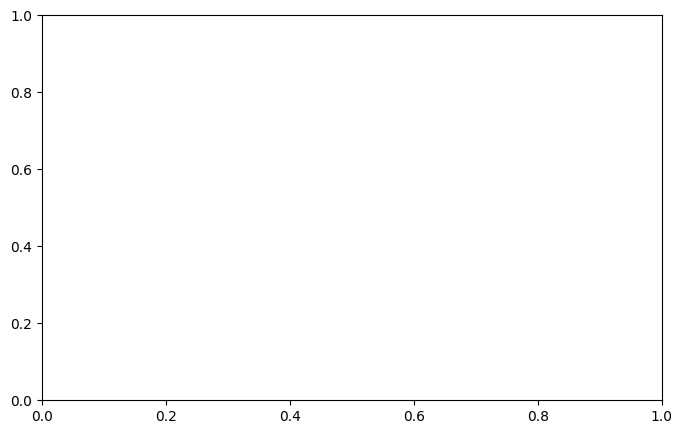

In [ ]:
plot_model_comparison(result)

In [ ]:
import csv

# Example result dict (from your code above after running test_model)
result = {
    'raw_net_5_score': 0.82,
    'raw_net_10_score': 0.79,
    'raw_net_30_score': 0.76,
    'raw_net_60_score': 0.75,
    'baymin_net_5_score': 0.88,
    'baymin_net_10_score': 0.86,
    'baymin_net_30_score': 0.84,
    'baymin_net_60_score': 0.83,
}

# Write into CSV
with open("results.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["model", "net_size", "score"])  # header
    
    for key, score in result.items():
        # key format: "{model}_net_{size}_score"
        parts = key.split("_")
        model = parts[0]      # "raw" or "baymin"
        net_size = parts[2]   # "5", "10", etc.
        
        writer.writerow([model, net_size, score])

print("Results written to results.csv")